# Daily NY Subway Entries vs Citi Bike Trips between March and May 2019

## Importing MTA Data from SQL DB

In [1]:
import pandas as pd
import datetime as dt
import sqlite3

In [2]:
con = sqlite3.connect("mta_data_2019.db")

query = '''
SELECT *
from mta_data;
'''

# Load the data into a DataFrame
df = pd.read_sql_query(query, con)

con.close()

## Data cleaning - remove duplicate entries

In [3]:
mta = df.copy()

In [4]:
# Merge DATE and TIME columns and convert to datetime data type
mta["DATE_TIME"] = pd.to_datetime(mta.DATE + " " + mta.TIME)
mta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2653353 entries, 0 to 2653352
Data columns (total 12 columns):
 #   Column     Dtype         
---  ------     -----         
 0   C/A        object        
 1   UNIT       object        
 2   SCP        object        
 3   STATION    object        
 4   LINENAME   object        
 5   DIVISION   object        
 6   DATE       object        
 7   TIME       object        
 8   DESC       object        
 9   ENTRIES    int64         
 10  EXITS      int64         
 11  DATE_TIME  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 242.9+ MB


In [5]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(mta.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
700871,N071,R013,00-06-00,34 ST-PENN STA,2019-04-20 08:00:00,2
527332,JFK03,R536,00-03-02,JFK JAMAICA CT1,2019-04-07 01:00:00,2
698273,N071,R013,00-00-01,34 ST-PENN STA,2019-02-28 07:00:00,2
699383,N071,R013,00-00-03,34 ST-PENN STA,2019-02-28 07:00:00,2
2166799,R283,R221,00-00-00,167 ST,2019-04-15 12:00:00,2


Since we are only taking the last reading of ENTRIES for each day, we should be okay to remove these duplicate records.

In [6]:
# Get rid of the duplicate entry, and sort by date
mta.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ignore_index=True)
mta.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [7]:
# Sanity Check again to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(mta.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-02-23 03:00:00,1
1768812,R141,R031,00-06-00,34 ST-PENN STA,2019-03-26 12:00:00,1
1768834,R141,R031,00-06-00,34 ST-PENN STA,2019-03-30 04:00:00,1
1768835,R141,R031,00-06-00,34 ST-PENN STA,2019-03-30 08:00:00,1
1768836,R141,R031,00-06-00,34 ST-PENN STA,2019-03-30 12:00:00,1


In [8]:
# Drop Exits and Desc Column.  To prevent errors in multiple run of cell, errors on drop is ignored
mta = mta.drop(["EXITS", "DESC"], axis=1, errors="ignore")

## Calculate daily entries

In [9]:
mta_daily = mta.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE']).ENTRIES.max().reset_index()
mta_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,02/23/2019,6956147
1,A002,R051,02-00-00,59 ST,02/24/2019,6956566
2,A002,R051,02-00-00,59 ST,02/25/2019,6957918
3,A002,R051,02-00-00,59 ST,02/26/2019,6959323
4,A002,R051,02-00-00,59 ST,02/27/2019,6960662


In [10]:
mta_daily[["PREV_DATE", "PREV_ENTRIES"]] = (mta_daily
                                            .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                            .apply(lambda grp: grp.shift(1)))
mta_daily

<ipython-input-10-296f81baec1f>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mta_daily[["PREV_DATE", "PREV_ENTRIES"]] = (mta_daily


,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,02/23/2019,6956147,NaN,NaN
1,A002,R051,02-00-00,59 ST,02/24/2019,6956566,02/23/2019,6956147.0
2,A002,R051,02-00-00,59 ST,02/25/2019,6957918,02/24/2019,6956566.0
3,A002,R051,02-00-00,59 ST,02/26/2019,6959323,02/25/2019,6957918.0
4,A002,R051,02-00-00,59 ST,02/27/2019,6960662,02/26/2019,6959323.0
...,...,...,...,...,...,...,...,...
439545,TRAM2,R469,00-05-01,RIT-ROOSEVELT,05/20/2019,5554,05/19/2019,5554.0
439546,TRAM2,R469,00-05-01,RIT-ROOSEVELT,05/21/2019,5554,05/20/2019,5554.0
439547,TRAM2,R469,00-05-01,RIT-ROOSEVELT,05/22/2019,5554,05/21/2019,5554.0
439548,TRAM2,R469,00-05-01,RIT-ROOSEVELT,05/23/2019,5554,05/22/2019,5554.0


In [11]:
# Drop the rows for the earliest date in the df
mta_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [12]:
mta_daily

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST,02/24/2019,6956566,02/23/2019,6956147.0
2,A002,R051,02-00-00,59 ST,02/25/2019,6957918,02/24/2019,6956566.0
3,A002,R051,02-00-00,59 ST,02/26/2019,6959323,02/25/2019,6957918.0
4,A002,R051,02-00-00,59 ST,02/27/2019,6960662,02/26/2019,6959323.0
5,A002,R051,02-00-00,59 ST,02/28/2019,6962053,02/27/2019,6960662.0
...,...,...,...,...,...,...,...,...
439545,TRAM2,R469,00-05-01,RIT-ROOSEVELT,05/20/2019,5554,05/19/2019,5554.0
439546,TRAM2,R469,00-05-01,RIT-ROOSEVELT,05/21/2019,5554,05/20/2019,5554.0
439547,TRAM2,R469,00-05-01,RIT-ROOSEVELT,05/22/2019,5554,05/21/2019,5554.0
439548,TRAM2,R469,00-05-01,RIT-ROOSEVELT,05/23/2019,5554,05/22/2019,5554.0


## Treating the readings that do not make sense

In [13]:
mta_daily[mta_daily["ENTRIES"] < mta_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
6774,A025,R023,01-00-00,34 ST-HERALD SQ,03/06/2019,4403519,03/05/2019,2.659450e+07
6865,A025,R023,01-00-01,34 ST-HERALD SQ,03/06/2019,12433113,03/05/2019,2.663712e+07
6956,A025,R023,01-00-02,34 ST-HERALD SQ,03/06/2019,13579331,03/05/2019,1.449794e+07
7219,A025,R023,01-03-01,34 ST-HERALD SQ,02/24/2019,1238697925,02/23/2019,1.238700e+09
7220,A025,R023,01-03-01,34 ST-HERALD SQ,02/25/2019,1238696075,02/24/2019,1.238698e+09


In [14]:
# Let's see how many stations have this problem
(mta_daily[mta_daily["ENTRIES"] < mta_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A   UNIT  SCP       STATION        
A025  R023  01-00-00  34 ST-HERALD SQ     1
            01-00-01  34 ST-HERALD SQ     1
            01-00-02  34 ST-HERALD SQ     1
            01-03-01  34 ST-HERALD SQ    90
            01-06-00  34 ST-HERALD SQ     1
                                         ..
R623  R061  00-00-01  NOSTRAND AV         2
R629  R065  00-00-00  ROCKAWAY AV         1
R645  R110  00-03-00  FLATBUSH AV-B.C     3
R646  R110  01-00-01  FLATBUSH AV-B.C    90
R730  R431  00-00-04  EASTCHSTER/DYRE    86
Length: 345, dtype: int64

In [15]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed? let's reverse it back
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0 between two days?
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
mta_daily["DAILY_ENTRIES"] = mta_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

In [16]:
mta_daily.DAILY_ENTRIES.describe()

count    434645.000000
mean       1197.897415
std        8117.993233
min           0.000000
25%         265.000000
50%         811.000000
75%        1586.000000
max      973762.000000
Name: DAILY_ENTRIES, dtype: float64

In [17]:
# Group by station to have daily entries by station
station_daily = mta_daily.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,02/24/2019,0.0
1,1 AV,02/25/2019,18477.0
2,1 AV,02/26/2019,19727.0
3,1 AV,02/27/2019,20144.0
4,1 AV,02/28/2019,20527.0


In [18]:
# Sum by date
sum_daily = mta_daily.groupby("DATE")[['DAILY_ENTRIES']].sum().reset_index()
sum_daily.head()

,DATE,DAILY_ENTRIES
0,02/24/2019,2325501.0
1,02/25/2019,5724727.0
2,02/26/2019,6044215.0
3,02/27/2019,7024669.0
4,02/28/2019,6168336.0


# Plotting Subway Ridership Trend

In [19]:
sum_daily['DATE'] = pd.to_datetime(sum_daily['DATE'])
sum_daily['seven_day_rolling_avg'] = sum_daily.DAILY_ENTRIES.rolling(7).mean()
sum_daily.head(8)
#sum_daily.dtypes

,DATE,DAILY_ENTRIES,seven_day_rolling_avg
0,2019-02-24,2325501.0,NaN
1,2019-02-25,5724727.0,NaN
2,2019-02-26,6044215.0,NaN
3,2019-02-27,7024669.0,NaN
4,2019-02-28,6168336.0,NaN
5,2019-03-01,6639958.0,NaN
6,2019-03-02,4197740.0,5.446449e+06
7,2019-03-03,2678249.0,5.496842e+06


In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme()

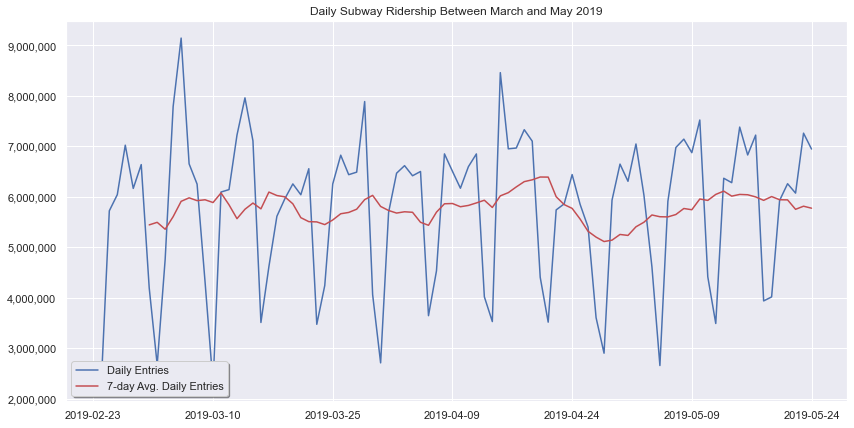

In [21]:
#fig = plt.figure(figsize = [15, 10])
#ax = fig.add_subplot()

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(sum_daily.DATE, sum_daily.DAILY_ENTRIES, label='Daily Entries')
ax.plot(sum_daily.DATE, sum_daily['seven_day_rolling_avg'], c='r', label='7-day Avg. Daily Entries')
ax.set_title('Daily Subway Ridership Between March and May 2019')
ax.legend(shadow = True, loc = 3)
ax.ticklabel_format(axis='y', style='plain')
ax.get_yaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

## Import Citi Bike data from SQL DB

In [22]:
con = sqlite3.connect("citi_bike_2019.db")

query = '''
SELECT starttime, startstationname
from tripdata;
'''

# Load the data into a DataFrame
bike_df = pd.read_sql_query(query, con, parse_dates='starttime')

con.close()

In [23]:
bike_df.head()

,starttime,startstationname
0,2019-03-01 00:00:16.097,Fulton St & Broadway
1,2019-03-01 00:00:32.385,E 4 St & 2 Ave
2,2019-03-01 00:00:47.797,E 33 St & 5 Ave
3,2019-03-01 00:01:01.209,6 Ave & Spring St
4,2019-03-01 00:01:09.281,W 31 St & 7 Ave


In [24]:
#bike_daily = bike_df.groupby(bike_df.starttime.dt.isocalendar().week).starttime.count().to_frame()
bike_daily = bike_df.groupby(bike_df.starttime.dt.date).starttime.count().to_frame()
bike_daily['seven_day_rolling_avg'] = bike_daily.starttime.rolling(7).mean()

In [25]:
bike_daily.head(8)

,starttime,seven_day_rolling_avg
starttime,,
2019-03-01,30233,NaN
2019-03-02,18001,NaN
2019-03-03,23239,NaN
2019-03-04,28421,NaN
2019-03-05,37097,NaN
2019-03-06,33279,NaN
2019-03-07,35907,29453.857143
2019-03-08,40406,30907.142857


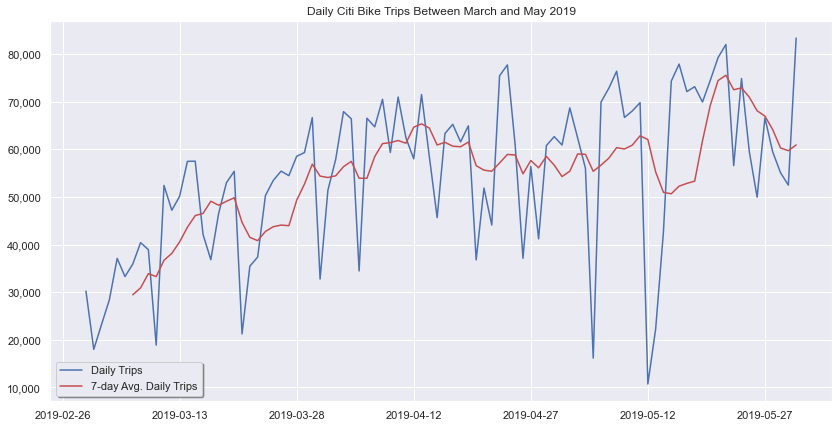

In [26]:
#fig = plt.figure(figsize = [15, 10])
#ax = fig.add_subplot()

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(bike_daily.index, bike_daily.starttime, label='Daily Trips')
ax.plot(bike_daily.index, bike_daily.seven_day_rolling_avg, c='r', label='7-day Avg. Daily Trips')
ax.set_title('Daily Citi Bike Trips Between March and May 2019')
ax.legend(shadow = True, loc = 3)
ax.get_yaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));
#ax.set_xlim([dt.date(2020, 3, 1), dt.date(2020, 5, 31)])

# Some Preliminary Plots 

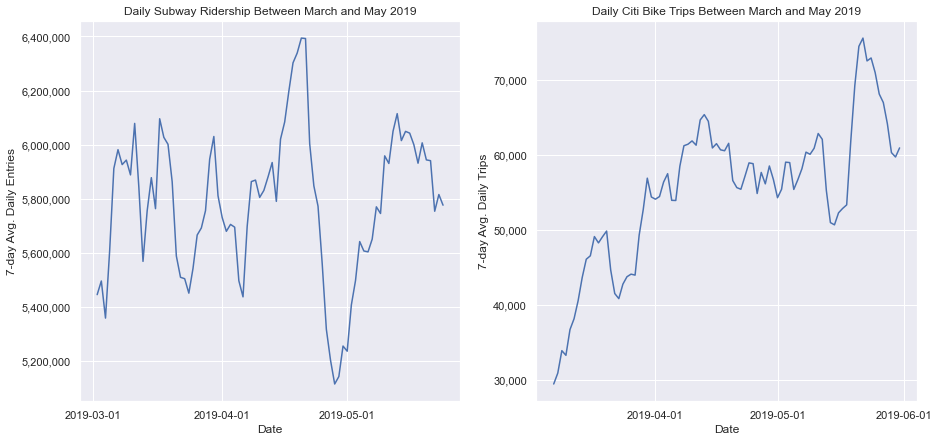

In [27]:
#plt.figure(figsize=[16,7])  

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

ax1.plot(sum_daily.DATE, sum_daily.seven_day_rolling_avg)
ax1.set(xlabel='Date', ylabel="7-day Avg. Daily Entries",
       title="Daily Subway Ridership Between March and May 2019")
ax1.get_yaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.grid(True);

ax2.plot(bike_daily.index, bike_daily.seven_day_rolling_avg)
ax2.set(xlabel='Date', ylabel="7-day Avg. Daily Trips",
       title='Daily Citi Bike Trips Between March and May 2019')
ax2.get_yaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.grid(True);

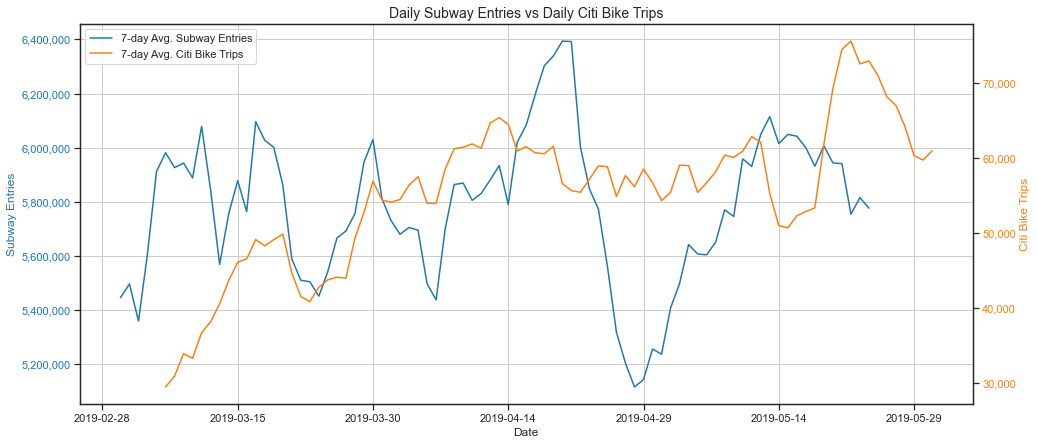

In [28]:
# Set seaborn style to ticks
sns.set_style('ticks')

fig, ax1 = plt.subplots(figsize=(16, 7))

p1, = ax1.plot(sum_daily.DATE, sum_daily.seven_day_rolling_avg,
               c='tab:blue', label='7-day Avg. Subway Entries')
ax1.set_title('Daily Subway Entries vs Daily Citi Bike Trips', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Subway Entries', color='tab:blue')
ax1.get_yaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

ax2 = ax1.twinx() 

p2, =ax2.plot(bike_daily.index, bike_daily.seven_day_rolling_avg,
              c='tab:orange', label='7-day Avg. Citi Bike Trips')
ax2.get_yaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_ylabel("Citi Bike Trips", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
lns = [p1, p2]
ax1.legend(handles=lns, loc=2)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

plt.savefig('result_2019.png')